In [1]:
# set root directory
import os

os.chdir("../")
os.getcwd()

'c:\\Users\\HP\\Desktop\\clustering-moroccan-weather-data'

In [2]:
# imports
import numpy as np
import pandas as pd

In [3]:
# imports for plots
from plotly import graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio

pio.templates.default = "plotly_white"

In [4]:
# load data
# weather variables to use
selected_cols = ["cumulative_GDD", "cumulative_PREC", "cumulative_WS2M", "cumulative_RH2M"]

dict_data = {}

for col in selected_cols:
  pathname = f"processed_data/{col}.csv"

  dict_data[col] = pd.read_csv(pathname, index_col=0)

In [5]:
# function to aggregate data
# aggregation by mean
def aggregate_data(data):
  return np.mean(data.values, axis=0)

# create data frame of aggregated data
aggregated_data = pd.DataFrame()

for col in selected_cols:
  aggregated_data[col] = aggregate_data(dict_data[col])

aggregated_data

,cumulative_GDD,cumulative_PREC,cumulative_WS2M,cumulative_RH2M
0,21.150769,1.100513,1.834103,59.658462
1,42.307436,2.399487,3.751282,118.211026
2,63.716538,3.654103,5.608462,178.530256
3,84.996282,5.778974,7.837179,241.111538
4,106.240769,7.982051,10.203333,303.233333
...,...,...,...,...
264,4579.296923,503.602051,572.560000,17160.703846
265,4606.836026,503.667692,574.913077,17205.780000
266,4634.609872,503.706154,577.336410,17251.305641
267,4662.670385,503.748718,579.601026,17296.356154


In [6]:
# train a standard scaler
from sklearn.preprocessing import StandardScaler

# build then train
standard_scaler = StandardScaler()
standard_scaler.fit(aggregated_data)

# transform data 
standarized_data = pd.DataFrame(standard_scaler.transform(aggregated_data), columns=selected_cols)

In [7]:
# check aggregation
fig = go.Figure(data=[
                      go.Scatter(y=standarized_data[col], name=col)
                      for col in selected_cols
])

fig.show()

In [8]:
# perform explanatory PCA decomposition
from sklearn.decomposition import PCA

# build and fit
pca = PCA()
pca.fit(standarized_data)

print(pca.explained_variance_ratio_)
# print(pca.components_)

[9.89318934e-01 1.04612977e-02 1.83848713e-04 3.59193691e-05]


In [9]:
# stacked bar chart view explained variance ratio
# pick up the appropriate number of component

component_names = [f"component_{i}" for i in range(1, len(selected_cols) + 1)]

fig = go.Figure(data=[
                      go.Bar(y=["Explained variance ratio"], x=[pca.explained_variance_ratio_[i]], name=component_names[i], orientation='h')
                      for i in range(len(selected_cols))
])


fig.update_layout(
    title_text="Explained variance ratio for each PC",
    height=500,
    width=1000,
    barmode="stack",
    xaxis={
    "tickformat": ',.0%',
    "range": [0,1]
  }
)

fig.show()

In [10]:
# Reduce dimension using PCA
# keep 1 component
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(standarized_data)

PCA(n_components=1)

In [11]:
# contribution of each weather variable in PC
pca.components_

array([[-0.4988385 , -0.49682952, -0.50187259, -0.50243853]])

We trained a PCA model to perform dimension reduction.
A crop year will be represented as a matrix (269 x 3)
We will perform dimension reduction on each crop year to get from (269 x 3) --> (269 x 1)

**Description of the pipeline**

1. split original data set to crop year matrices
2. standarize these crop year using the trained standarized_scaler
3. reduce dimension of each crop year using the trained pca
4. gather all these crop years in a data frame (39 x 269)

This is the data that will be used in to cluster crop years


**Clustering** 
All we need to do is to pass this data frame through the clustering pipeline


In [12]:
# load original data
original_data = pd.read_csv("raw_data/processed_weather_3.csv")

In [13]:
# pre procecss following the description above

clustering_data = pd.DataFrame()

for crop_year in original_data["crop_year"].unique():
  # selected crop year an its weather variables
  query = original_data["crop_year"] == crop_year
  data = original_data[query][selected_cols].copy()

  # standarize and reduce dimension
  data = standard_scaler.transform(data)
  data = pca.transform(data)

  # add to data frame
  clustering_data[crop_year] = data.T[0]

# transpose to get the desired data frame
# with crop years as observations

clustering_data = clustering_data.T
clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,3.517127,3.494108,3.474145,3.448851,3.428882,3.408964,3.388273,3.366136,3.334631,3.285613,...,-3.506731,-3.534060,-3.565444,-3.589398,-3.611688,-3.633430,-3.656981,-3.680257,-3.701050,-3.722852
1983,3.518062,3.500729,3.482375,3.447764,3.423598,3.401874,3.324231,3.267786,3.235268,3.205137,...,-2.674268,-2.699006,-2.720699,-2.742065,-2.764131,-2.786745,-2.808564,-2.830362,-2.851240,-2.874152
1984,3.516991,3.497026,3.475757,3.457537,3.438448,3.420530,3.403129,3.386716,3.365230,3.334229,...,-3.032240,-3.053559,-3.073287,-3.094001,-3.116245,-3.139892,-3.162007,-3.184852,-3.208819,-3.233725
1985,3.516042,3.495539,3.476207,3.457289,3.437889,3.406618,3.389126,3.366275,3.347074,3.327043,...,-2.593008,-2.617912,-2.639813,-2.662107,-2.683375,-2.705386,-2.727311,-2.751593,-2.774862,-2.796507
1986,3.511996,3.492907,3.476072,3.457344,3.437362,3.419269,3.401677,3.381961,3.362386,3.341550,...,-3.008008,-3.029426,-3.051470,-3.073408,-3.095175,-3.117820,-3.140501,-3.163254,-3.185804,-3.205993
1987,3.515747,3.494282,3.475601,3.452729,3.433129,3.414284,3.395216,3.373824,3.353083,3.333529,...,-2.835823,-2.861285,-2.887280,-2.927867,-2.954036,-2.976940,-2.999190,-3.024711,-3.051500,-3.075900
1988,3.516950,3.493143,3.472989,3.455119,3.434459,3.408423,3.388952,3.369718,3.348265,3.314626,...,-2.930641,-2.952947,-2.976074,-2.999868,-3.026234,-3.049384,-3.072602,-3.095648,-3.115060,-3.136203
1989,3.497290,3.467078,3.426839,3.369542,3.314233,3.296357,3.277892,3.260033,3.242318,3.224610,...,-2.877820,-2.898773,-2.921851,-2.945311,-2.967601,-2.989821,-3.012579,-3.035243,-3.057899,-3.078882
1990,3.475534,3.449722,3.430770,3.407149,3.381889,3.362730,3.344141,3.321738,3.296132,3.270458,...,-3.245512,-3.267846,-3.290803,-3.312207,-3.334693,-3.357481,-3.380181,-3.408553,-3.431771,-3.453110
1991,3.503172,3.479734,3.455287,3.421119,3.387196,3.365972,3.334391,3.292864,3.270811,3.231941,...,-3.190127,-3.211439,-3.234899,-3.260719,-3.284159,-3.306212,-3.327764,-3.351825,-3.373021,-3.394786


In [14]:
# plot data
# impossible to interprate results
x = clustering_data.columns

fig = go.Figure()

# number of the years
for i in range(0, 39):
  fig.add_trace(
      go.Scatter(x=x, y=clustering_data.values[i], name=str(clustering_data.index[i]))
  )
  

fig.update_layout(
    title="for crop year",
    height=500,
    width=800
)

fig.show()

In [15]:
metric = "euclidean"
linkage_method = "ward"

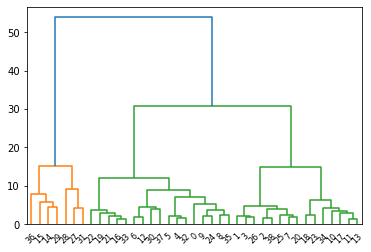

In [16]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(clustering_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [17]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = clustering_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [18]:
clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,3.517127,3.494108,3.474145,3.448851,3.428882,3.408964,3.388273,3.366136,3.334631,3.285613,...,-3.506731,-3.534060,-3.565444,-3.589398,-3.611688,-3.633430,-3.656981,-3.680257,-3.701050,-3.722852
1983,3.518062,3.500729,3.482375,3.447764,3.423598,3.401874,3.324231,3.267786,3.235268,3.205137,...,-2.674268,-2.699006,-2.720699,-2.742065,-2.764131,-2.786745,-2.808564,-2.830362,-2.851240,-2.874152
1984,3.516991,3.497026,3.475757,3.457537,3.438448,3.420530,3.403129,3.386716,3.365230,3.334229,...,-3.032240,-3.053559,-3.073287,-3.094001,-3.116245,-3.139892,-3.162007,-3.184852,-3.208819,-3.233725
1985,3.516042,3.495539,3.476207,3.457289,3.437889,3.406618,3.389126,3.366275,3.347074,3.327043,...,-2.593008,-2.617912,-2.639813,-2.662107,-2.683375,-2.705386,-2.727311,-2.751593,-2.774862,-2.796507
1986,3.511996,3.492907,3.476072,3.457344,3.437362,3.419269,3.401677,3.381961,3.362386,3.341550,...,-3.008008,-3.029426,-3.051470,-3.073408,-3.095175,-3.117820,-3.140501,-3.163254,-3.185804,-3.205993
1987,3.515747,3.494282,3.475601,3.452729,3.433129,3.414284,3.395216,3.373824,3.353083,3.333529,...,-2.835823,-2.861285,-2.887280,-2.927867,-2.954036,-2.976940,-2.999190,-3.024711,-3.051500,-3.075900
1988,3.516950,3.493143,3.472989,3.455119,3.434459,3.408423,3.388952,3.369718,3.348265,3.314626,...,-2.930641,-2.952947,-2.976074,-2.999868,-3.026234,-3.049384,-3.072602,-3.095648,-3.115060,-3.136203
1989,3.497290,3.467078,3.426839,3.369542,3.314233,3.296357,3.277892,3.260033,3.242318,3.224610,...,-2.877820,-2.898773,-2.921851,-2.945311,-2.967601,-2.989821,-3.012579,-3.035243,-3.057899,-3.078882
1990,3.475534,3.449722,3.430770,3.407149,3.381889,3.362730,3.344141,3.321738,3.296132,3.270458,...,-3.245512,-3.267846,-3.290803,-3.312207,-3.334693,-3.357481,-3.380181,-3.408553,-3.431771,-3.453110
1991,3.503172,3.479734,3.455287,3.421119,3.387196,3.365972,3.334391,3.292864,3.270811,3.231941,...,-3.190127,-3.211439,-3.234899,-3.260719,-3.284159,-3.306212,-3.327764,-3.351825,-3.373021,-3.394786


In [19]:
# perform clustring for k = nb_cluster
from sklearn.cluster import AgglomerativeClustering

# number of clusters
# determined from the plot above
nb_cluster = 3

# data
X = clustering_data

# build clustering model
model = AgglomerativeClustering(n_clusters=nb_cluster, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# assign cluster lable to each observation
cluster_labels = model.fit_predict(X)

In [20]:
cluster_labels

array([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1], dtype=int64)

In [21]:
# create centered data
centered_clustering_data = pd.DataFrame()

for col in clustering_data.columns:
  centered_clustering_data[col] = clustering_data[col] - clustering_data[col].mean()

In [22]:
centered_clustering_data

,0,1,2,3,4,5,6,7,8,9,...,259,260,261,262,263,264,265,266,267,268
1982,0.003127,0.004014,0.007914,0.010447,0.018902,0.025783,0.031759,0.038276,0.031836,0.009587,...,-0.391171,-0.395355,-0.403582,-0.404329,-0.403671,-0.402580,-0.403459,-0.403797,-0.402049,-0.401145
1983,0.004062,0.010636,0.016143,0.009360,0.013618,0.018693,-0.032283,-0.060074,-0.067527,-0.070890,...,0.441292,0.439698,0.441163,0.443004,0.443885,0.444105,0.444959,0.446097,0.447761,0.447555
1984,0.002991,0.006933,0.009526,0.019133,0.028468,0.037349,0.046616,0.058855,0.062435,0.058202,...,0.083319,0.085145,0.088575,0.091068,0.091771,0.090958,0.091515,0.091608,0.090182,0.087982
1985,0.002041,0.005445,0.009975,0.018885,0.027909,0.023437,0.032612,0.038415,0.044280,0.051016,...,0.522551,0.520793,0.522050,0.522962,0.524641,0.525464,0.526211,0.524867,0.524139,0.525200
1986,-0.002004,0.002814,0.009840,0.018940,0.027382,0.036088,0.045164,0.054101,0.059591,0.065524,...,0.107551,0.109278,0.110392,0.111662,0.112842,0.113030,0.113021,0.113206,0.113197,0.115714
1987,0.001747,0.004189,0.009369,0.014325,0.023149,0.031103,0.038702,0.045964,0.050288,0.057502,...,0.279737,0.277419,0.274583,0.257202,0.253980,0.253910,0.254333,0.251749,0.247502,0.245807
1988,0.002949,0.003050,0.006757,0.016715,0.024479,0.025242,0.032438,0.041858,0.045470,0.038599,...,0.184918,0.185758,0.185789,0.185201,0.181782,0.181466,0.180920,0.180812,0.183941,0.185504
1989,-0.016711,-0.023016,-0.039392,-0.068862,-0.095747,-0.086824,-0.078622,-0.067827,-0.060477,-0.051417,...,0.237739,0.239931,0.240012,0.239758,0.240415,0.241028,0.240943,0.241216,0.241102,0.242825
1990,-0.038467,-0.040372,-0.035462,-0.031255,-0.028091,-0.020451,-0.012373,-0.006123,-0.006663,-0.005569,...,-0.129952,-0.129142,-0.128940,-0.127138,-0.126677,-0.126631,-0.126659,-0.132093,-0.132770,-0.131403
1991,-0.010829,-0.010359,-0.010944,-0.017285,-0.022784,-0.017209,-0.022123,-0.034996,-0.031983,-0.044085,...,-0.074567,-0.072735,-0.073036,-0.075650,-0.076142,-0.075362,-0.074241,-0.075365,-0.074019,-0.073079


In [23]:
# perform explanatory PCA decomposition
from sklearn.decomposition import PCA

# build and fit
pca = PCA()
pca.fit(centered_clustering_data)

print(pca.explained_variance_ratio_)

[8.91785441e-01 6.30360754e-02 1.93014726e-02 1.13822331e-02
 3.55485372e-03 3.08944919e-03 1.53259961e-03 1.36783997e-03
 8.35510801e-04 6.35573532e-04 5.30193465e-04 4.42152220e-04
 4.15750116e-04 3.14743935e-04 2.76862659e-04 2.14543595e-04
 1.84305437e-04 1.59930555e-04 1.33304482e-04 1.08545605e-04
 8.62849247e-05 7.68681072e-05 6.97484772e-05 6.61706316e-05
 6.16074170e-05 5.22250866e-05 4.64239144e-05 4.08486876e-05
 3.49172703e-05 2.75916237e-05 2.47373743e-05 2.24797006e-05
 2.16982397e-05 2.07954810e-05 1.48815316e-05 1.22750707e-05
 1.05231722e-05 8.54247655e-06 5.11648221e-33]


In [24]:
# keep 7 components

from sklearn.decomposition import PCA

pca = PCA(n_components=7)
pca.fit(centered_clustering_data)

transformed_centered_clustering_data = pd.DataFrame(pca.transform(centered_clustering_data), index=centered_clustering_data.index)

In [25]:
transformed_centered_clustering_data

,0,1,2,3,4,5,6
1982,2.089901,3.229400,0.010079,1.222429,-0.762516,0.702977,-0.334611
1983,-4.129919,-0.480439,-0.487418,-0.762654,0.459750,-0.049768,-0.522485
1984,-2.658507,-0.093927,0.832327,1.196100,-0.101570,0.353198,-0.229923
1985,-5.944844,-0.712311,-0.214305,-0.098402,-0.275869,0.332005,-0.009812
1986,-1.842261,2.052649,-0.853830,-0.758254,0.290363,0.241502,0.020316
1987,-2.176814,1.330452,-1.985951,-1.759612,0.208101,0.976161,0.177957
1988,-1.258750,-1.148630,-0.809349,0.127106,0.187452,0.091944,0.051733
1989,-4.130412,1.246355,1.460614,-0.035578,0.248615,0.014847,0.264168
1990,1.738425,-1.303008,0.326532,1.204389,-0.076794,-0.169378,0.147071
1991,1.310648,0.725076,0.553722,-0.524171,1.162480,-0.676573,-0.067866


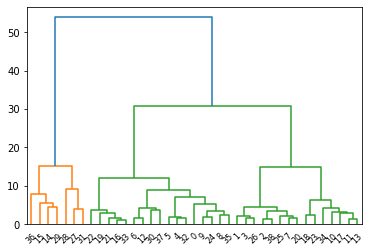

In [26]:
# dendrogram to have an idea about aggregation procedure
# and the evolution between cluster distance

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

Z = linkage(transformed_centered_clustering_data, metric=metric, method=linkage_method)
# fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

In [27]:
# use Calanski-Harabasz index
# to choose the right number of cluster

from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics


# where to store CH index
arr_calanski = {}

# max possible number of cluster
max_k = 10

# data
X = transformed_centered_clustering_data

# loop over number of clusters
for k in range(2, max_k):
  # build model 
  model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method, affinity=metric)
  model = model.fit(X)

  # clusters label
  labels = model.fit_predict(X)

  # compute calanski metric
  m = metrics.calinski_harabasz_score(X, labels)

  arr_calanski[k] = m


# plot of CH index
fig = go.Figure(data=[
                      go.Scatter(x=list(arr_calanski.keys()), y=list(arr_calanski.values()))
])

fig.update_layout(
    width=800,
    height=500,
    xaxis_title="number of cluster",
    yaxis_title="Calanski-Harbasz index"
)

fig.show()

In [28]:
# perform clustring for k = nb_cluster
from sklearn.cluster import AgglomerativeClustering

# number of clusters
# determined from the plot above
nb_cluster = 3

# data
X = transformed_centered_clustering_data

# build clustering model
model = AgglomerativeClustering(n_clusters=nb_cluster, linkage=linkage_method, affinity=metric)
model = model.fit(X)

# assign cluster lable to each observation
cluster_labels = model.fit_predict(X)

In [29]:
cluster_labels

array([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1], dtype=int64)

In [33]:
print([2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1])

[2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 0, 2, 1]
